In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from comet_ml import Experiment
from taa_utils import *
import math
import os
import pickle
import joblib
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Mejores Modelos

In [2]:
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# Descarto Label, Weight y EventId

y_train = df_train['Label']
EventId = df_train['EventId']
X_train = df_train.drop(['EventId', 'Weight', 'Label'], axis=1)

# Transforma labels a binario.
y_train, _ = labels_a_binario(y_train, _)

In [4]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Reemplaza outiers con nan.
        X_nan = X.replace(-999, np.nan)
        
        # Drop de las columnas que terminan con phi.
        X_nan_sin_phi = X_nan.drop(columns= ['PRI_tau_phi',
                                             'PRI_lep_phi',
                                             'PRI_met_phi',
                                             'PRI_jet_leading_phi',
                                             'PRI_jet_subleading_phi'])
        
        # Drop de las columnas con pocos datos y baja corr. que se decidieron descartar.
        X_nan_sin_phi = X_nan_sin_phi.drop(columns = ['PRI_jet_subleading_eta', 
                                                      'PRI_jet_subleading_pt'])
        
        # Calcula los porcentajes de no-nan para cada columna
        X_result = X_nan_sin_phi.drop(columns = ['PRI_jet_all_pt',  
                                                 'PRI_met_sumet'])
        
               
        return X_result

In [5]:
def save_results(cmt_exp, cross_val_results):
    '''
    Entrada:
        cmt_exp: experimento comet
        cross_val_scores: scikit-learn cross validation results
    '''

    ### Registro de Métricas de Evaluación ###
    fit_time = cross_val_results['fit_time']
    cv_f1 = cross_val_results['test_f1']
    cv_roc = cross_val_results['test_roc_auc']
   
    ### Resultados para cada fold ###
    for k in range(fit_time.size):
        metrics_step = {
            'Fit Time':fit_time[k],
            'f1':cv_f1[k],
            'roc':cv_roc[k],
        }
        cmt_exp.log_metrics(metrics_step,step=k)

    ### Registro de Gráficas ###
    plt.figure()
    plt.plot(cross_val_results['test_f1'],'*-')
    plt.xlabel('fold')
    plt.ylabel('f1')
    plt.title('Cross validation f1')
    plt.grid()
    
    cmt_exp.log_figure(figure_name="CV_f1" ,figure=plt)
   
    return

In [6]:
API_KEY = '4758xmPFeCo55aLIV3xaKbPU2' # Se puede encontrar en Settings(Arriba a la derecha en Comet)

## Decision Tree

In [7]:
DT_pipeline = Pipeline([
    ('Transform', CustomTransformer()),
    ('Imputer', SimpleImputer(strategy='mean')),
    ('Classifier', DecisionTreeClassifier(max_depth=20, min_samples_leaf=50, random_state=42))
])

In [10]:
# Cross validation
kfolds = StratifiedKFold(10)
scores_dt = cross_validate(estimator=DT_pipeline,
                        X=X_train, 
                        y=y_train,
                        scoring=['f1','roc_auc'],
                        cv=kfolds.split(X_train, y_train),
                        return_train_score=True,
                        return_estimator=True,
                        error_score='raise',
                        verbose=-2,
                        n_jobs=-1,
                       )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   12.4s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   12.7s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s finished


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Franco\\Desktop\\Franco\\Facultad\\Fing\\2023\\Semestre 1\\TAA\\Proyecto 1' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
COMET INFO: Experiment is live on comet.com https://www.comet.com/franco-berrutti/proy1/e29fa79aab604de683a80299f5fde71e

C

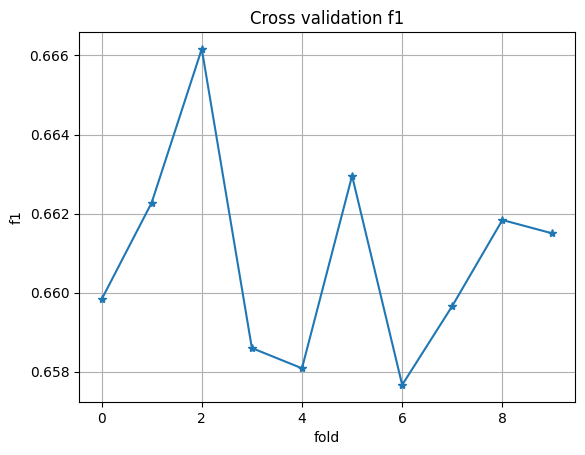

In [11]:
#Creo un experimento con la API KEY
exp_dt = Experiment(api_key=API_KEY,  
                 project_name='PROY1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp_dt.set_name('DT') # Nombre de este experimento
exp_dt.add_tags(['dt']) # Tags

exp_dt.log_parameters(DT_pipeline.get_params())
exp_dt.log_parameter("modelo","dt")
save_results(exp_dt,scores_dt)
exp_dt.end()

## Random Forest

In [12]:
RF_pipeline = Pipeline([
    ('Transform', CustomTransformer()),
    ('Imputer', SimpleImputer(strategy='mean')),
    ('Classifier', RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=5, n_estimators=300, random_state=42))
])


In [15]:
# Cross validation
kfolds = StratifiedKFold(10)
scores_rf = cross_validate(estimator=RF_pipeline,
                        X=X_train, 
                        y=y_train,
                        scoring=['f1','roc_auc'],
                        cv=kfolds.split(X_train, y_train),
                        return_train_score=True,
                        return_estimator=True,
                        error_score='raise',
                        n_jobs=-1,
                       )

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Franco\\Desktop\\Franco\\Facultad\\Fing\\2023\\Semestre 1\\TAA\\Proyecto 1' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
COMET INFO: Experiment is live on comet.com https://www.comet.com/franco-berrutti/proy1/0728df229ba749b8b2e877720fa3cb54

C

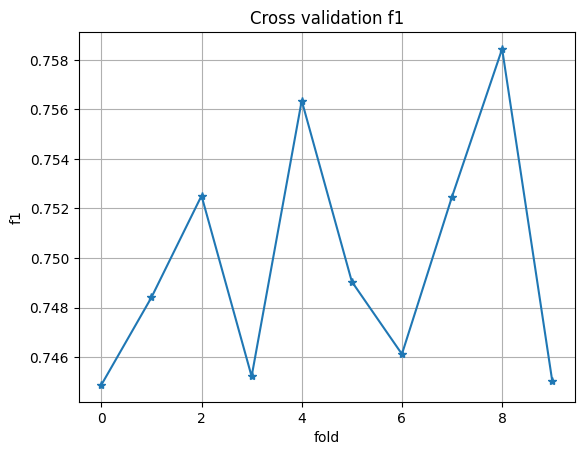

In [16]:
#Creo un experimento con la API KEY
exp_rf = Experiment(api_key=API_KEY,  
                 project_name='PROY1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp_rf.set_name('RF') # Nombre de este experimento
exp_rf.add_tags(['rf']) # Tags

exp_rf.log_parameters(RF_pipeline.get_params())
exp_rf.log_parameter("modelo","rf")
save_results(exp_rf,scores_rf)
exp_rf.end()

## XGBoost

In [7]:
# Pipeline de pre-procesamiento
xgb_pipeline = Pipeline([
    ('Transform', CustomTransformer()),
    ('Imputer', SimpleImputer(strategy='mean')),
    ('Classifier', XGBClassifier(colsample_bytree=0.7,learning_rate=0.01,max_depth=15,n_estimators=200,subsample=0.5,random_state=42))
])

In [13]:
# Cross validation
kfolds = StratifiedKFold(10)
scores_xgb = cross_validate(estimator=XGB_pipeline,
                        X=X_train, 
                        y=y_train,
                        scoring=['f1','roc_auc'],
                        cv=kfolds.split(X_train, y_train),
                        return_train_score=True,
                        return_estimator=True,
                        error_score='raise',
                        n_jobs=-1,
                       )

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/franco-berrutti/proy1/1ca94d4f651e4d9db3a21764b3167111
COMET INFO:   Others:
COMET INFO:     Name : RF
COMET INFO:   Parameters:
COMET INFO:     Classifier                          : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categoric

COMET INFO:     Classifier__base_score              : 1
COMET INFO:     Classifier__booster                 : 1
COMET INFO:     Classifier__callbacks               : 1
COMET INFO:     Classifier__colsample_bylevel       : 1
COMET INFO:     Classifier__colsample_bynode        : 1
COMET INFO:     Classifier__colsample_bytree        : 0.7
COMET INFO:     Classifier__early_stopping_rounds   : 1
COMET INFO:     Classifier__enable_categorical      : False
COMET INFO:     Classifier__eval_metric             : 1
COMET INFO:     Classifier__feature_types           : 1
COMET INFO:     Classifier__gamma                   : 1
COMET INFO:     Classifier__gpu_id                  : 1
COMET INFO:     Classifier__grow_policy             : 1
COMET INFO:     Classifier__importance_type         : 1
COMET INFO:     Classifier__interaction_constraints : 1
COMET INFO:     Classifier__learning_rate           : 0.01
COMET INFO:     Classifier__max_bin                 : 1
COMET INFO:     Classifier__max_cat_thr

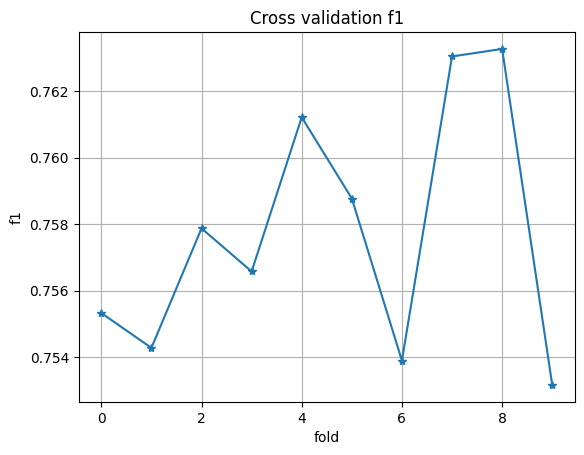

In [15]:
# Commet
#Creo un experimento con la API KEY
exp_xgb = Experiment(api_key=API_KEY,  
                 project_name='PROY1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp_xgb.set_name('xgb') # Nombre de este experimento
exp_xgb.add_tags(['xgb']) # Tags

exp_xgb.log_parameters(XGB_reg_model.get_params())
exp_xgb.log_parameter("modelo","xgb")
save_results(exp_xgb,scores_xgb)
exp_xgb.end()

# Preprocesamientos


In [ ]:
(X_train, X_val, y_train, y_val, pesos_train, pesos_val, 
 valor_esperado_signal, valor_esperado_background) = divideConjuntos(df_train)

X_train, X_val, y_train, y_val, pesos_train, pesos_val = actualizaPesos(X_train, X_val, y_train, y_val, pesos_train, 
                                                            pesos_val, valor_esperado_signal, valor_esperado_background)


y_train, y_val = labels_a_binario(y_train, y_val)

EventID_train, X_train = dropEventID(X_train)
EventID_val, X_val = dropEventID(X_val)

## Eliminar todas las columnas que contengan datos faltantes

In [ ]:
X_train_sin_nan =  drop999(X_train)
X_val_sin_nan =  drop999(X_val)

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold

clf_1 = RandomForestClassifier(class_weight='balanced', max_depth=15, min_samples_leaf=5, n_estimators=75)


skf = StratifiedKFold(10)
score = cross_validate(clf_1,
                        X_train_sin_nan,
                        y_train,
                        scoring=["f1", "roc_auc"],
                        cv=skf.split(X_train_sin_nan, y_train),
                        verbose=3,
                        n_jobs=-1)


In [ ]:
#Creo un experimento con la API KEY
API_KEY = '4758xmPFeCo55aLIV3xaKbPU2' # Se puede encontrar en Settings(Arriba a la derecha en Comet)
exp_dt = Experiment(api_key=API_KEY,  
                 project_name='PROY1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp_dt.set_name('Sin_nan') # Nombre de este experimento
exp_dt.add_tags(['Sin_nan']) # Tags

exp_dt.log_parameters(clf_1.get_params())
exp_dt.log_parameter("modelo","dt")
save_results(exp_dt,score)
exp_dt.end()

## Eliminar columnas con más del 70% de datos faltantes


In [ ]:
X_train_nan = X_train.replace(-999, np.nan)
X_val_nan = X_val.replace(-999, np.nan)
largo = len(X_train)
non_null_counts = X_train_nan.count() *(100/X_train_nan.shape[0]) #serie con los porcentajes de not null de cada columna

menores_a_30 = non_null_counts[non_null_counts < 30]

lista_menores_a_30 = menores_a_30.index.to_list() #lista que tiene los nombres de las columnas con menos de 30% de not null

In [ ]:
X_train_30 =  X_train_nan.drop(columns = lista_menores_a_30)
X_val_30 =  X_val_nan.drop(columns = lista_menores_a_30)

imputer_30 = SimpleImputer(strategy='mean')

X_train_30 = pd.DataFrame(imputer_30.fit_transform(X_train_30), columns=X_train_30.columns)
X_val_30 =   pd.DataFrame(imputer_30.transform(X_val_30), columns=X_val_30.columns)

In [ ]:
clf_2 = RandomForestClassifier(max_depth=15, min_samples_leaf=5)

skf = StratifiedKFold(10)
score = cross_validate(clf_2,
                        X_train_30,
                        y_train,
                        scoring=["f1", "roc_auc"],
                        cv=skf.split(X_train, y_train),
                        verbose=3,
                        n_jobs=-1)

In [ ]:
#Creo un experimento con la API KEY
API_KEY = '4758xmPFeCo55aLIV3xaKbPU2' # Se puede encontrar en Settings(Arriba a la derecha en Comet)
exp_dt = Experiment(api_key=API_KEY,  
                 project_name='PROY1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp_dt.set_name('Sin_Datos_faltantes_30%') # Nombre de este experimento
exp_dt.add_tags(['Sin_Datos_faltantes_30%']) # Tags

exp_dt.log_parameters(clf_2.get_params())
exp_dt.log_parameter("modelo","dt")
save_results(exp_dt, score)
exp_dt.end()

## Eliminar columnas con más del 40% de datos faltantes

In [ ]:
X_train_nan = X_train.replace(-999, np.nan)
X_val_nan = X_val.replace(-999, np.nan)
largo = len(X_train)
non_null_counts = X_train_nan.count() *(100/X_train_nan.shape[0]) #serie con los porcentajes de not null de cada columna

menores_a_60 = non_null_counts[non_null_counts < 60]

lista_menores_a_60 = menores_a_60.index.to_list() #lista que tiene los nombres de las columnas con menos de 60% de not null

In [ ]:
X_train_60 =  X_train_nan.drop(columns = lista_menores_a_60)
X_val_60 =  X_val_nan.drop(columns = lista_menores_a_60)

imputer = SimpleImputer(strategy='mean')

X_train_60 = pd.DataFrame(imputer.fit_transform(X_train_60), columns=X_train_60.columns)
X_val_60 =   pd.DataFrame(imputer.transform(X_val_60), columns=X_val_60.columns)

In [ ]:
clf_3 = RandomForestClassifier(max_depth=13, min_samples_leaf=5)

skf = StratifiedKFold(10)
score = cross_validate(clf_3,
                        X_train_60,
                        y_train,
                        scoring=["f1", "roc_auc"],
                        cv=skf.split(X_train, y_train),
                        verbose=3,
                        n_jobs=-1)

In [ ]:
#Creo un experimento con la API KEY
API_KEY = '4758xmPFeCo55aLIV3xaKbPU2' # Se puede encontrar en Settings(Arriba a la derecha en Comet)
exp_dt = Experiment(api_key=API_KEY,  
                 project_name='PROY1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp_dt.set_name('Sin_Datos_faltantes_60%') # Nombre de este experimento
exp_dt.add_tags(['Sin_Datos_faltantes_60%']) # Tags

exp_dt.log_parameters(clf_3.get_params())
exp_dt.log_parameter("modelo","dt")
save_results(exp_dt, score)
exp_dt.end()

## PCA

In [ ]:
imputer = SimpleImputer(strategy='mean')

X_train_pca = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val_pca =   pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [ ]:
scaler = StandardScaler()

X_train_pca = pd.DataFrame(scaler.fit_transform(X_train_pca), columns=X_train_pca.columns)
X_val_pca =   pd.DataFrame(scaler.transform(X_val_pca), columns=X_val_pca.columns)

In [ ]:
pca = PCA(n_components=0.99)

X_train_pca = pca.fit_transform(X_train_pca)
X_val_pca = pca.transform(X_val_pca)

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold

clf_pca = RandomForestClassifier(class_weight='balanced', max_depth=19, min_samples_leaf=15)

skf = StratifiedKFold(10)
score = cross_validate(clf_pca,
                        X_train_pca,
                        y_train,
                        scoring=["f1", "roc_auc"],
                        cv=skf.split(X_train_pca, y_train),
                        verbose=3,
                        n_jobs=-1)

In [ ]:
#Creo un experimento con la API KEY
API_KEY = '4758xmPFeCo55aLIV3xaKbPU2' # Se puede encontrar en Settings(Arriba a la derecha en Comet)
exp_dt = Experiment(api_key=API_KEY,  
                 project_name='PROY1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp_dt.set_name('PCA_99') # Nombre de este experimento
exp_dt.add_tags(['PCA']) # Tags

exp_dt.log_parameters(clf_pca.get_params())
exp_dt.log_parameter("modelo","dt")
save_results(exp_dt,score)
exp_dt.end()